In [1]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load('10.0GHz_0ppm.npz')
calib_data = np.load('0_tx1_rx1_rx_rotate.npz')

In [2]:
txtd = data['txtd']
rxtd_10 = data['rxtd_10.0']
calib_rxtd_10 = calib_data['rxtd_10.0']

In [3]:
print(f"TX shape: {txtd.shape}, RX shape: {rxtd_10.shape}, Calib RX shape: {calib_rxtd_10.shape}")

TX shape: (1, 2, 1024), RX shape: (256, 2, 1024), Calib RX shape: (32, 2, 1024)


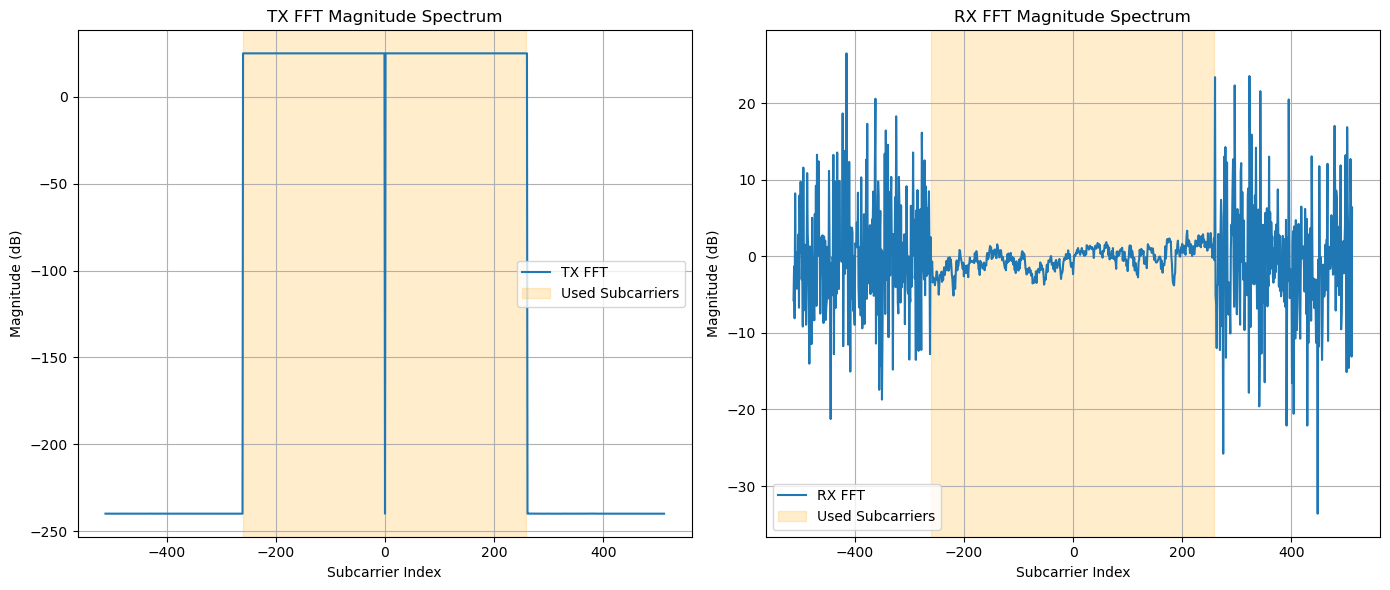

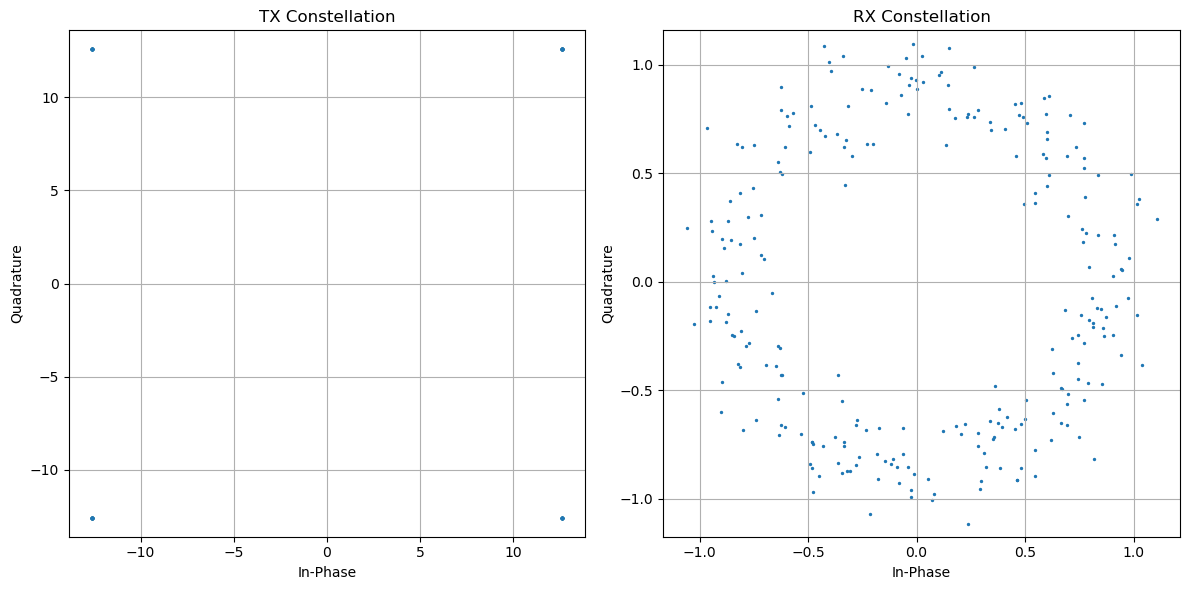

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Squeeze the data to remove single-dimensional entries
txtd = np.squeeze(txtd)  # TX data

# Choose RX frame and antenna
rx_frame = rxtd_10[0][0]  # RX frame 0, antenna 0 → shape (1024,)
tx_signal = txtd[0]      # TX antenna 0 → shape (1024,)
calib_rx_frame = calib_rxtd_10[0][0]  # Calibrated RX frame 0, antenna 0 → shape (1024,)

# ---- FFT and shift ----
rx_fft = np.fft.fftshift(np.fft.fft(rx_frame, n=1024))
tx_fft = np.fft.fftshift(np.fft.fft(tx_signal, n=1024))
calib_rx_fft = np.fft.fftshift(np.fft.fft(calib_rx_frame, n=1024))

# ---- Antenna Calibration ----
rx_fft /= np.abs(calib_rx_fft)

# ---- Extract subcarriers [-260 to +259] (i.e., indices 251 to 770) ----
used_idx = np.zeros_like(rx_fft, dtype=bool)
used_idx[252:512] = True  # Subcarriers -260 to +259
# used_idx[513:770] = True  # Subcarriers -260 to +259
rx_syms = rx_fft[used_idx]
tx_syms = tx_fft[used_idx]

# Subcarrier index axis
subcarrier_index = np.arange(-512, 512)

# Plot full FFT
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(subcarrier_index, 20*np.log10(np.abs(tx_fft) + 1e-12), label="TX FFT")
plt.title("TX FFT Magnitude Spectrum")
plt.xlabel("Subcarrier Index")
plt.ylabel("Magnitude (dB)")
plt.axvspan(-261, 259, color='orange', alpha=0.2, label="Used Subcarriers")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(subcarrier_index, 20*np.log10(np.abs(rx_fft) + 1e-12), label="RX FFT")
plt.title("RX FFT Magnitude Spectrum")
plt.xlabel("Subcarrier Index")
plt.ylabel("Magnitude (dB)")
plt.axvspan(-261, 259, color='orange', alpha=0.2, label="Used Subcarriers")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# ---- Plot constellations ----
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(np.real(tx_syms), np.imag(tx_syms), s=2, label="TX")
plt.title("TX Constellation")
plt.xlabel("In-Phase")
plt.ylabel("Quadrature")
plt.axis("equal")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(np.real(rx_syms), np.imag(rx_syms), s=2, label="RX")
plt.title("RX Constellation")
plt.xlabel("In-Phase")
plt.ylabel("Quadrature")
plt.axis("equal")
plt.grid(True)

plt.tight_layout()
plt.show()


In [5]:
len(tx_syms), len(rx_syms)

(260, 260)

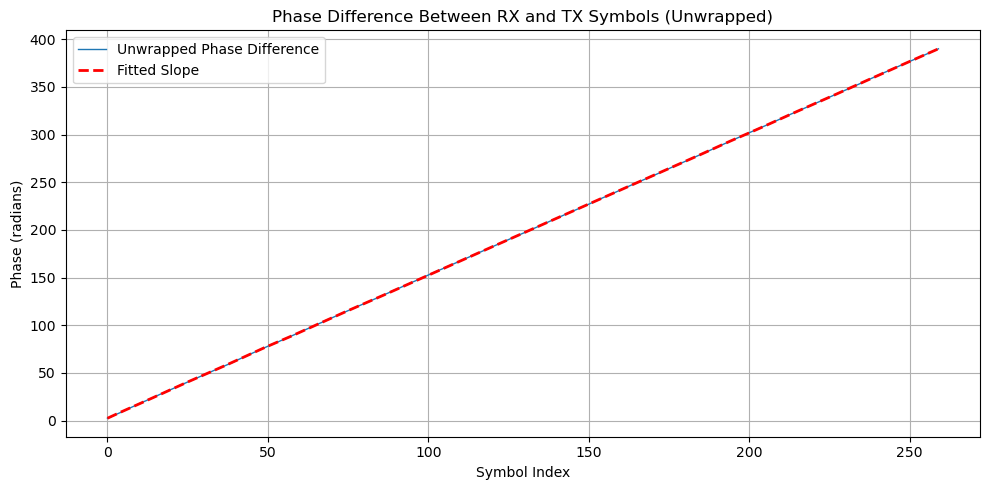

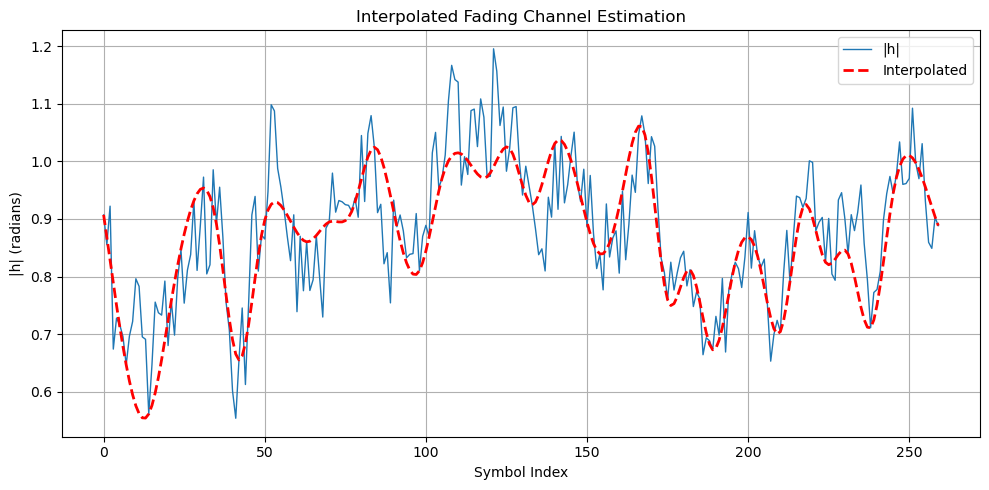

In [6]:
# Assume tx and rx are same known symbol, but rx has CFO
fs = 983.04e6  # Example sampling rate in Hz (replace with your actual fs)
Ts = 1 / fs  # Sampling interval
# phase difference
tx_syms = tx_syms / np.sqrt(tx_syms * np.conj(tx_syms))
sym_err = rx_syms * np.conj(tx_syms) / (tx_syms * np.conj(tx_syms))
phase_diff = np.angle(sym_err)
h_abs = np.abs(sym_err)
phase_unwrapped = np.unwrap(phase_diff)

f_cfo = np.mean(np.diff(phase_unwrapped[:100])) / (2 * np.pi * Ts)  # Ts = sampling interval
sym_idx = np.arange(len(phase_unwrapped))+1

from scipy.interpolate import interp1d 

pilot_interval = 7 # pilot in every 7 symbol
# linear fit to get slope
n = np.arange(len(phase_unwrapped))
f = interp1d(n[::pilot_interval], phase_unwrapped[::pilot_interval], kind='cubic')
phase_interp = f(n)

f = interp1d(n[::pilot_interval], h_abs[::pilot_interval], kind='cubic')  
h_interp = f(n)

# Step 4: Plot
plt.figure(figsize=(10, 5))
plt.plot(phase_unwrapped, label="Unwrapped Phase Difference", linewidth=1)
plt.plot(n, phase_interp, '--r', label=f"Fitted Slope", linewidth=2)
plt.xlabel("Symbol Index")
plt.ylabel("Phase (radians)")
plt.title("Phase Difference Between RX and TX Symbols (Unwrapped)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Step 4: Plot
plt.figure(figsize=(10, 5))
plt.plot(h_abs, label="|h|", linewidth=1)
plt.plot(n, h_interp, '--r', label=f"Interpolated", linewidth=2)
plt.xlabel("Symbol Index")
plt.ylabel("|h| (radians)")
plt.title("Interpolated Fading Channel Estimation")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


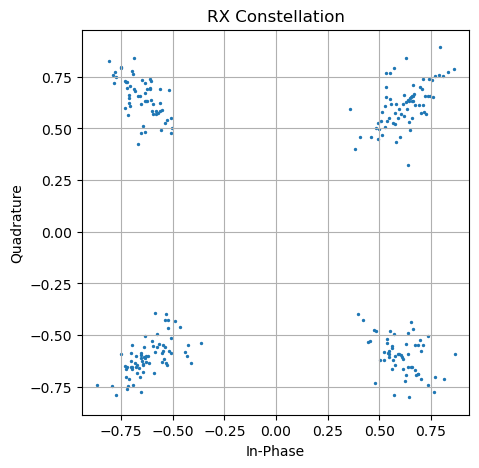

In [7]:
rx_eq = [sym*np.exp(-1j * phase_interp[i]) for i, sym in enumerate(rx_syms)]
plt.figure(figsize=(5, 5))

plt.scatter(np.real(rx_eq), np.imag(rx_eq), s=2, label="RX Equalized")
plt.title("RX Constellation")
plt.xlabel("In-Phase")
plt.ylabel("Quadrature")
plt.axis("equal")
plt.grid(True)

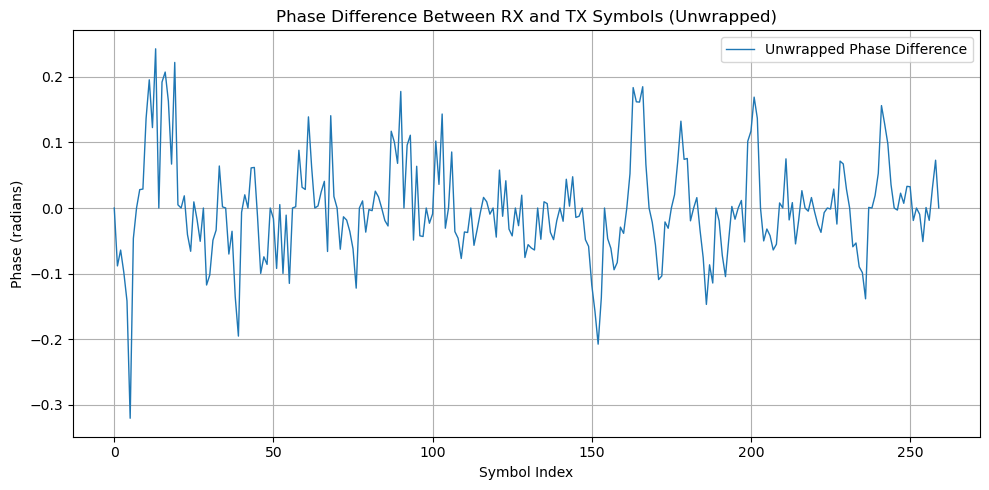

In [8]:
# phase difference
phase_diff = np.angle(rx_eq * np.conj(tx_syms))
phase_unwrapped = np.unwrap(phase_diff)
init_est = phase_unwrapped[0]

# Step 4: Plot
plt.figure(figsize=(10, 5))
plt.plot(phase_unwrapped, label="Unwrapped Phase Difference", linewidth=1)
plt.xlabel("Symbol Index")
plt.ylabel("Phase (radians)")
plt.title("Phase Difference Between RX and TX Symbols (Unwrapped)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
import numpy as np

def decision_qpsk(symbol, h_est=None):
    """
    Distance-based decision for QPSK symbols.

    Parameters:
        symbol : complex or np.ndarray
            The received symbol(s) to decide on

    Returns:
        decision : complex or np.ndarray
            Nearest QPSK constellation point(s)
    """

    if h_est is None:
        h_est = np.ones_like(symbol)

    # Define ideal QPSK constellation points (at 45°, 135°, 225°, 315°)
    qpsk_constellation = np.exp(1j * (np.pi/4 + np.pi/2 * np.arange(4)))  # [π/4, 3π/4, 5π/4, 7π/4]

    symbol = np.asarray(symbol)  # Ensure array input

    distances = np.abs(symbol - h_est*qpsk_constellation)
    idx = np.argmin(distances)
    decision = qpsk_constellation[idx]

    return decision, idx


def pll_qpsk(received, kp=0.05, phase_init=0.0, h_est=None):
    """
    QPSK symbol-space PLL with PD loop filter
    Parameters:
        received : np.ndarray
            Received QPSK symbols
        kp : float
            Proportional gain
        phase_init : float
            Initial phase estimate
    Returns:
        corrected : np.ndarray
            Phase-corrected symbols
        phase_track : np.ndarray
            Phase estimates
    """
    if h_est is None:
        h_est = np.ones_like(received)

    N = len(received)
    corrected = np.zeros(N, dtype=complex)
    phase_track = np.zeros(N)
    phase_est = phase_init

    for n in range(N):
        # Apply current phase correction
        y_init = received[n] * np.exp(-1j * phase_est)

        # QPSK decision
        d, _ = decision_qpsk(y_init, h_est[n])

        # Phase error
        error = np.angle(y_init * np.conj(d)/(d * np.conj(d)))
        # Proportional loop filter
        phase_est += kp * error 

        # Store corrected symbol and phase
        corrected[n] = received[n] * np.exp(-1j * phase_est)
        phase_track[n] = phase_est

    return corrected, phase_track


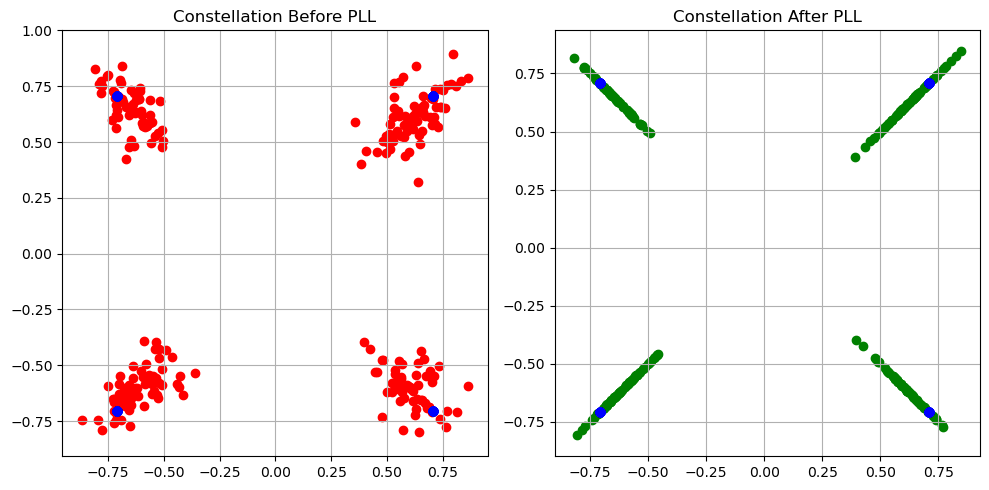

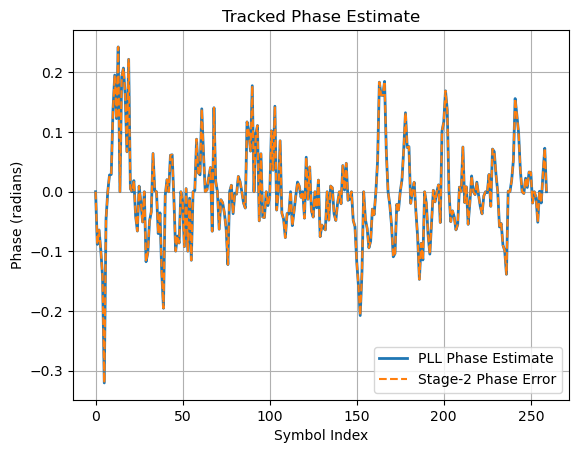

In [10]:
corrected, phase_track = pll_qpsk(rx_eq, kp=1.0, phase_init=init_est, h_est=h_interp)

# Plot constellation before and after PLL
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(np.real(rx_eq), np.imag(rx_eq), color='red', label='Before PLL')
plt.scatter(np.real(tx_syms), np.imag(tx_syms), color='blue', label='Before PLL')
plt.title("Constellation Before PLL")
plt.grid(True)
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.scatter(np.real(corrected), np.imag(corrected), color='green', label='After PLL')
plt.scatter(np.real(tx_syms), np.imag(tx_syms), color='blue', label='Before PLL')
plt.title("Constellation After PLL")
plt.grid(True)
plt.axis('equal')

plt.tight_layout()
plt.show()

# Optional: plot phase tracking
plt.figure()
plt.plot(phase_track, label="PLL Phase Estimate", linewidth=2.0)
plt.plot(phase_unwrapped, linestyle='--', label="Stage-2 Phase Error", linewidth=1.5)
plt.title("Tracked Phase Estimate")
plt.xlabel("Symbol Index")
plt.ylabel("Phase (radians)")
plt.legend()
plt.grid(True)
plt.show()

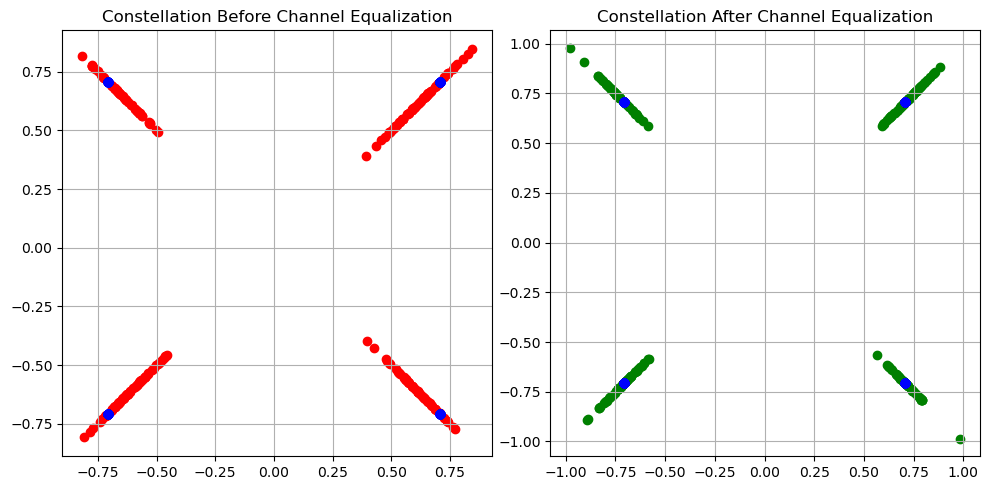

In [11]:
rx_eq2 = corrected / h_interp

# Plot constellation before and after equalization
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(np.real(corrected), np.imag(corrected), color='red', label='Before PLL')
plt.scatter(np.real(tx_syms), np.imag(tx_syms), color='blue', label='Before PLL')
plt.title("Constellation Before Channel Equalization")
plt.grid(True)
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.scatter(np.real(rx_eq2), np.imag(rx_eq2), color='green', label='After PLL')
plt.scatter(np.real(tx_syms), np.imag(tx_syms), color='blue', label='Before PLL')
plt.title("Constellation After Channel Equalization")
plt.grid(True)
plt.axis('equal')

plt.tight_layout()
plt.show()

In [12]:
decisions = np.zeros_like(rx_eq2, dtype=complex)
tx_idxs = np.zeros_like(rx_eq2, dtype=complex)

for i, sym in enumerate(rx_eq2):
    decision, idx = decision_qpsk(sym)
    decisions[i] = idx
    decision, idx = decision_qpsk(tx_syms[i])
    tx_idxs[i] = idx

print(f"Decision matrix after equalization: {decisions == tx_idxs}\n")


Decision matrix after equalization: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  T

In [13]:
for i, sym in enumerate(rx_syms):
    decision, idx = decision_qpsk(sym)
    decisions[i] = idx

print(f"Decision matrix original rx: {decisions == tx_idxs}")

Decision matrix original rx: [False False False  True False False False  True False False False  True
 False False False  True False False False  True False False False  True
 False False False  True False False False False  True False False False
  True False False False  True False False False  True False False False
  True False False False  True  True False False False  True False False
 False  True False False False  True False False False  True False False
 False  True  True False False False  True False False False  True False
 False False  True False False False  True  True False False False  True
 False False False  True False False False  True False False False  True
 False False False  True False False False False  True False False False
  True False False False  True False False False  True False False False
 False  True False False False  True False False False  True False False
 False  True False False False  True  True False False False  True False
 False False  True Fal

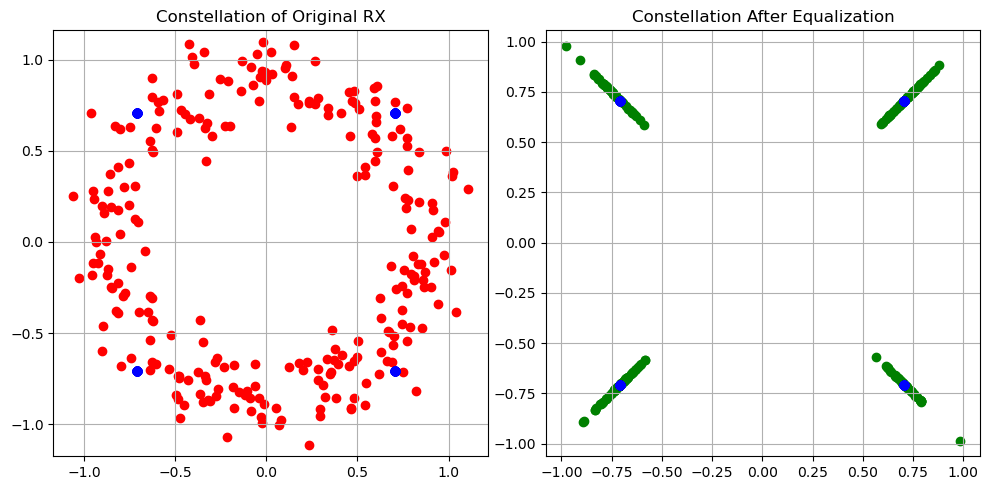

In [14]:
# Plot constellation original and after equalization
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(np.real(rx_syms), np.imag(rx_syms), color='red', label='Before PLL')
plt.scatter(np.real(tx_syms), np.imag(tx_syms), color='blue', label='Before PLL')
plt.title("Constellation of Original RX")
plt.grid(True)
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.scatter(np.real(rx_eq2), np.imag(rx_eq2), color='green', label='After PLL')
plt.scatter(np.real(tx_syms), np.imag(tx_syms), color='blue', label='Before PLL')
plt.title("Constellation After Equalization")
plt.grid(True)
plt.axis('equal')

plt.tight_layout()
plt.show()